# Capstone Project - The Battle of the Neighborhoods (Week 4)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project inspired by a new apartment search journey of a friend of mine. It has been a journey that consumed a lot of time and effort for my friend personally and I was thinking it would be nice to have some service that can serve normal requirements or special requirements for any of us to **search for a new home to settle**. 
Below is the main factor that would affect my friend's decision on which house to buy or which areas to live 
 1. Close distance to work by cycling
 My friend loves cycling and he would like to live where it doesn't take a lot of time in commuting to work place and his prefer transportantion is bicycling 
 2. The place is close to shore and has convenience and close access to boat places.
 One of the big hobby is rowing. My friend would love to live in places where boat docking places are nearby
 3. House price is affordable. 
 Ofcourse, my friend wants to have the best deal that a place can offer to his needs including good prices
 4. Last check points: The neigbourhoods - what it has to offer the new resident

This report is aim to solve an interesting problem for individual needs. 
First we will try to **define the large areas base on travel distance by bicycling to a specific workplace** In this report I will use my friend workplace in Helsinki areas as an example and a target for defining travel distances.

After that, we will **mark the boat docking places in Helsinki large area** so help targeting a list of neigbourhood base on postal codes to narrow down the search. 

On top of that, we will **visualise the average house prices of each postal code area** and find the places/areas which will offer optimal distance to work place, close to boat docks and having lowest average price per square meters (m2) 

Since we will have the list of promissing postal code areas to look in, we can **explore each neigbourhood too see what kind of services it has to offer to normal urban life** and provide well defined information so that my friend is well equipped with data and such has better chance to choose the most suitable new home. 

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* travel time to the work place: ideal time is 16 minutes one way and the average is 20-30 minutes. My friend prefers something below 25 minutes.
* the availability of boat docks in the neighborhood: the more the merrier
* unit price per square m2 of an apartment : the lower the better
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Italian restaurants in the neighborhood, if any


Following data sources will be needed to extract/generate the required information:
* coordinate of the work place, which is **Pasila in Helsinki center** will be obtained using **Nominatim**: this data will be the target for calculating travel times 
* Spatial data from OpenStreetMap and to visualize, and analyze real-world street networks and calculate travel times. 
* Location data of the boat docks avaialble in Helsinki metropolitan area (Helsinki, Espoo, Vantaa, and Kauniainen).This data will be used to visualise on map for location of boat docks
* Unit price per square meters for houses (all type of houses) in Helsinki metropolitan area. This data will be used to visualise on Chorolepth map the average house price per square meter and it will help to pint point the areas where there are best price. 
* Location data of postal code areas belong to  Helsinki metropolitan area. This data will help to show postal code area on Chrolepth map. 
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API** . This data will be used to explore the neighbourhood of choices after the locations are defined


#### Here we also import all necessary libraries that we will use in this project 


In [6]:
# conert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# panda
import pandas as pd

# tranform JSON file into a pandas dataframe
from pandas import json_normalize 

# numpy
import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# plotting library
import folium

# dealing with different coordinates system
import pyproj
from pyproj import CRS

# library to handle api requests and respones
import urllib3
import json
import requests
import html5lib

# for OSM network calculation
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon

#library to read data from WFS webservice 
from owslib.wfs import WebFeatureService

#library to read geojson file to dataframe
#convert gml to geojson for use
import geopandas as gpd

### 1. Location of work place as target

#### My friend company is located in Pasila, Helsinki, Finland
We will find lat lon of Pasila using **Nominatim**

In [7]:
address = 'Pasila, Helsinki, Finland'

geolocator = Nominatim(user_agent="helsinki_explorer")
location = geolocator.geocode(address)

pasila_latitude = location.latitude
pasila_longitude = location.longitude

print('The geograpical coordinate of Pasila, Helsinki are {}, {}.'.format(pasila_latitude, pasila_longitude))

The geograpical coordinate of Pasila, Helsinki are 60.197873, 24.9322653.


**Now we have defined lat lon coordinates of the destination for calculating travel times which is Pasila (60.197873, 24.9322653)**

### 2. Spatial data from OpenStreetMaps to analyse and calculate travel times

We will get network data using OSMnx library and the **mode of transportation is "bike"** for bicycling (my friend most favourite transportation mean).
We will also put the **distance of the network from the center point to about 18 km** and get the initial network data for further calculation.


In [11]:
# Transportation mode - bicycling
mode = "bike"
# Create network graph from place and mode - this will return data in ESPG:4326 by default
G = ox.graph_from_point((pasila_latitude, pasila_longitude), dist=18000, simplify=True, network_type=mode, dist_type = 'network')



#### Plot the initial network map so that we have an idea on the spatial data we have

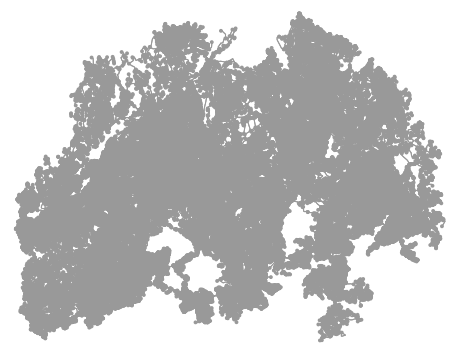

<Figure size 432x288 with 0 Axes>

In [14]:
# Plot the network graph
fig, ax = ox.plot_graph(G,  bgcolor="#ffffff", node_color = '#999999');
plt.tight_layout()
plt.show()

### 3.  Location data of the boat docks avaialble in Helsinki metropolitan area 

As it is an important requirement that the new home will have close access to boat docks. I could fine the infomration about boat docks location from City Service Map of Helsinki: https://palvelukartta.hel.fi/fi/search?q=venesatamat and download the result in JSON format. 

Consider the convenient usage of data, I uploaded it to github 

In [15]:
#Utility method to read json data from an url
def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    http = urllib3.PoolManager()
    response = http.request('GET',url, preload_content=False)
    data = json.loads(response.data.decode('utf-8'))
    response.release_conn()
    return data

In [16]:
hel_venesatamat_url = "https://raw.githubusercontent.com/maithoa/Coursera_Capstone/master/data_venesatamat.json"

data = get_jsonparsed_data(hel_venesatamat_url)


#Clean the json data and put it to a pandas frame

normalised_data  = json_normalize(data)

#json_data = pd.read_json(hel_venesatamat_url)
#json_data

#Filter needed columns 
filtered_columns = ['name.fi', 'location.coordinates','street_address.fi']
hel_venepaikat =normalised_data.loc[:, filtered_columns]

hel_venepaikat.dropna(axis = 0, inplace = True)
hel_venepaikat.shape

(186, 3)

In [17]:
hel_venepaikat

,name.fi,location.coordinates,street_address.fi
0,Pajalahden venesatama (Meripuistotie) / Venesa...,"[24.88903, 60.158215]",Meripuistotie 1a
1,Eläintarhanlahden venesatama,"[24.941782, 60.18]",Eläintarhantie 10
2,Kipparlahden venesatama,"[25.023306, 60.191067]",Kipparlahdenkuja 3
3,Laivalahden venesatama,"[25.027122, 60.186985]",Simppukarinkatu 2
4,Mesaanikujanlaituri / Venesatama,"[25.070076, 60.16623]",Mesaanikuja 11
...,...,...,...
182,Suomenojan saaristovenelaituri,"[24.719975, 60.14572]",Hylkeenpyytäjäntie 9
183,Taivalsaarenlaituri / Vesiliikennelaituri,"[24.90974, 60.176285]",Hiekkarannantie 3
184,Valkosaaren vierasvenesatama (NJK),"[24.964687, 60.160988]",Valkosaari
185,Valkosaarenlaituri / Vesiliikennelaituri,"[24.963524, 60.161438]",Valkosaari 1


We can see that **there are 186 boat docks around Helsinki Metropolitan Area** however the coordinates format is probably in (lon,lat) order. And also the data is not in correct format of a normal geometry point. So a bit *cleaning up to be done here: get the lat, lon data to separate columns so that it will be easier to use for visualisation purpose* 

In [19]:
new  = [pd.to_numeric(x) for x in hel_venepaikat['location.coordinates']]
df = hel_venepaikat['location.coordinates']
location_lat = []
location_lon = []
max_index = len(new)
for i in range (len(new)):
        location_lon.append(new[i].item(0))
        location_lat.append(new[i].item(1))

hel_venepaikat['location.longtitue'] = location_lon
hel_venepaikat['location.latitude'] = location_lat

print ("Data set of boat docks with separate columns for lat lon value")
hel_venepaikat

Data set of boat docks with separate columns for lat lon value


,name.fi,location.coordinates,street_address.fi,location.longtitue,location.latitude
0,Pajalahden venesatama (Meripuistotie) / Venesa...,"[24.88903, 60.158215]",Meripuistotie 1a,24.889030,60.158215
1,Eläintarhanlahden venesatama,"[24.941782, 60.18]",Eläintarhantie 10,24.941782,60.180000
2,Kipparlahden venesatama,"[25.023306, 60.191067]",Kipparlahdenkuja 3,25.023306,60.191067
3,Laivalahden venesatama,"[25.027122, 60.186985]",Simppukarinkatu 2,25.027122,60.186985
4,Mesaanikujanlaituri / Venesatama,"[25.070076, 60.16623]",Mesaanikuja 11,25.070076,60.166230
...,...,...,...,...,...
182,Suomenojan saaristovenelaituri,"[24.719975, 60.14572]",Hylkeenpyytäjäntie 9,24.719975,60.145720
183,Taivalsaarenlaituri / Vesiliikennelaituri,"[24.90974, 60.176285]",Hiekkarannantie 3,24.909740,60.176285
184,Valkosaaren vierasvenesatama (NJK),"[24.964687, 60.160988]",Valkosaari,24.964687,60.160988
185,Valkosaarenlaituri / Vesiliikennelaituri,"[24.963524, 60.161438]",Valkosaari 1,24.963524,60.161438


### 4.  Unit price per square meters for all house type in Helsinki Metropolitan area 

For urban houses unit price per square meter, I get data from Stat.fi service https://pxnet2.stat.fi/PXWeb/pxweb/fi/StatFin/StatFin__asu__ashi__vv/statfin_ashi_pxt_112q.px/ and saved data to an excel file and read the data

In [11]:
#Read excel house price 
file_path = "data/FI_asuntojen_hinnat.xlsx"
df_asuntojen_hinnat = pd.read_excel(file_path)

#read postinro and add column 
df_asuntojen_hinnat.dropna(inplace = True)


df_asuntojen_hinnat.columns = ['posno','Nimi', '1','Type','2','Year','Price_per_m2','Available_for_sale']
df = df_asuntojen_hinnat[['posno','Price_per_m2','Available_for_sale']]
df.head(20)


,posno,Price_per_m2,Available_for_sale
3,00100,8903,10
4,00120,..,1
5,00130,..,..
6,00140,..,4
7,00150,..,1
8,00160,..,..
9,00170,..,..
10,00180,8654,33
11,00190,..,..
12,00200,7690,20


#### Clean up the data to remove the row where there isn't any available for sale 


In [12]:
#need to average out the price per m2 and sum available_for sales per each postinumero
df = df[(df.Available_for_sale != '..') ]

#Conver value from text to float for prices and to integer for available houses
df["Price_per_m2"] = pd.to_numeric(df["Price_per_m2"], errors='coerce', downcast='float')
df["Available_for_sale"] = pd.to_numeric(df["Available_for_sale"], errors='coerce', downcast='integer')

df.sort_values(by=['posno'])
df

,posno,Price_per_m2,Available_for_sale
3,00100,8903.0,10
4,00120,NaN,1
6,00140,NaN,4
7,00150,NaN,1
10,00180,8654.0,33
...,...,...,...
1625,96460,2108.0,10
1628,96800,NaN,2
1629,96900,2708.0,6
1665,99555,NaN,3


In [13]:
# Group prices by Postal code 

df_hinnat = df.groupby('posno', as_index=False).agg(Avg_price_per_m2=('Price_per_m2','mean'), 
                                            No_of_available= ('Available_for_sale','sum'))
df_hinnat

,posno,Avg_price_per_m2,No_of_available
0,00100,8903.0,10
1,00120,NaN,1
2,00140,NaN,4
3,00150,NaN,1
4,00180,8654.0,33
...,...,...,...
602,96460,2108.0,10
603,96800,NaN,2
604,96900,2708.0,6
605,99555,NaN,3


As you can see from the price dataframe, there are some place that has availabe house however the price is not define. Which is completely fine. We will show what we have. 
However **we filtered out the postal code areas where there aren't any houses on sale.** The data we have from here contains all postal codes from Finland. Later when we join with location data from Helsinki Metropolitan area, we will have a smaller set of data


## 5. Geometry data of postal code areas

We will get geometry data of all postal code areas belong to Helsinki Metropolitan area using webservice wfs_hsy_url = 'https://kartta.hsy.fi/geoserver/wfs'
**Data return by wfs is in gml format. We will use 3rd party tool ogr2ogr to convert gml to geojson**

In [2]:
wfs_hsy_url = 'https://kartta.hsy.fi/geoserver/wfs'
wfs_2_11 = WebFeatureService(url= wfs_hsy_url, version='1.1.0')

In [3]:
#Read geometries of all postinumero belongs to Pääkaupunkiseutu - ESPG:3879
response = wfs_2_11.getfeature(typename='taustakartat_ja_aluejaot:pks_postinumeroalueet_2020')

a = wfs_2_11.get_schema('taustakartat_ja_aluejaot:pks_postinumeroalueet_2020')
#response.read()
a

{'properties': {'posno': 'string',
  'toimip': 'string',
  'toimip_ru': 'string',
  'nimi': 'string',
  'nimi_ru': 'string',
  'kunta': 'string',
  'kunta_nro': 'string'},
 'required': [],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'geom'}

#### As returned data is in KML format, we will save it first to KML file and convert it to "postinro_alue.geojson" geojson manually using ogr2ogr tool 

out = open('data_kml_pk_postinro.kml', 'wb')
result = response.read()
if isinstance(result, bytes):
    out.write(result)
else :
    out.write(bytes(result, 'UTF-8'))
    
out.close()
#result

#### Use geopandas to read geojson file to a dataframe

In [18]:

df_postinro = gpd.read_file("data/postinro_alue.geojson")
#df.head(1000)
df_postinro.head()

,gml_id,posno,toimip,toimip_ru,nimi,nimi_ru,kunta,kunta_nro,geometry
0,pks_postinumeroalueet_2020.1,00100,HELSINKI,HELSINGFORS,Helsinki Keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,Helsinki,091,"MULTIPOLYGON (((25495415.010 6673755.420, 2549..."
1,pks_postinumeroalueet_2020.2,00120,HELSINKI,HELSINGFORS,Punavuori,Rödbergen,Helsinki,091,"MULTIPOLYGON (((25496720.730 6672703.770, 2549..."
2,pks_postinumeroalueet_2020.3,00130,HELSINKI,HELSINGFORS,Kaartinkaupunki,Gardesstaden,Helsinki,091,"MULTIPOLYGON (((25496776.230 6672752.055, 2549..."
3,pks_postinumeroalueet_2020.4,00140,HELSINKI,HELSINGFORS,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,Helsinki,091,"MULTIPOLYGON (((25497132.180 6672015.420, 2549..."
4,pks_postinumeroalueet_2020.5,00150,HELSINKI,HELSINGFORS,Eira - Hernesaari,Eira - Ärtholmen,Helsinki,091,"MULTIPOLYGON (((25496970.120 6671136.315, 2549..."


#### Here we can also see that the coordinate is in ESPG:3879 coordinates systems. And in order to show it on Folium map we need to convert the data to ESPG:4326 (WGS84)

In [19]:
#set original CRS
df_postinro.crs = CRS.from_epsg(3879)

# Re-project to WGS84
df_postinro_geo = df_postinro.to_crs(epsg=4326)
df_postinro_geo.head()

,gml_id,posno,toimip,toimip_ru,nimi,nimi_ru,kunta,kunta_nro,geometry
0,pks_postinumeroalueet_2020.1,00100,HELSINKI,HELSINGFORS,Helsinki Keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,Helsinki,091,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60..."
1,pks_postinumeroalueet_2020.2,00120,HELSINKI,HELSINGFORS,Punavuori,Rödbergen,Helsinki,091,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60..."
2,pks_postinumeroalueet_2020.3,00130,HELSINKI,HELSINGFORS,Kaartinkaupunki,Gardesstaden,Helsinki,091,"MULTIPOLYGON (((24.94193 60.16764, 24.95107 60..."
3,pks_postinumeroalueet_2020.4,00140,HELSINKI,HELSINGFORS,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,Helsinki,091,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60..."
4,pks_postinumeroalueet_2020.5,00150,HELSINKI,HELSINGFORS,Eira - Hernesaari,Eira - Ärtholmen,Helsinki,091,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60..."


#### Finally, we will combine geometry data with the average house price and available houses to one dataframe for later to show on Chorolepth map

In [20]:
#merge the geo to get price and available number
df_postinro_geo = df_postinro_geo.merge(df_hinnat, left_on='posno', right_on='posno')
df_postinro_geo
 

,gml_id,posno,toimip,toimip_ru,nimi,nimi_ru,kunta,kunta_nro,geometry,Avg_price_per_m2,No_of_available
0,pks_postinumeroalueet_2020.1,00100,HELSINKI,HELSINGFORS,Helsinki Keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,Helsinki,091,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60...",8903.0,10
1,pks_postinumeroalueet_2020.2,00120,HELSINKI,HELSINGFORS,Punavuori,Rödbergen,Helsinki,091,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60...",NaN,1
2,pks_postinumeroalueet_2020.4,00140,HELSINKI,HELSINGFORS,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,Helsinki,091,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60...",NaN,4
3,pks_postinumeroalueet_2020.5,00150,HELSINKI,HELSINGFORS,Eira - Hernesaari,Eira - Ärtholmen,Helsinki,091,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60...",NaN,1
4,pks_postinumeroalueet_2020.8,00180,HELSINKI,HELSINGFORS,Kamppi - Ruoholahti,Kampen - Gräsviken,Helsinki,091,"MULTIPOLYGON (((24.92810 60.16730, 24.92805 60...",8654.0,33
...,...,...,...,...,...,...,...,...,...,...,...
115,pks_postinumeroalueet_2020.163,02780,ESPOO,ESBO,Kauklahti,Köklax,Espoo,049,"MULTIPOLYGON (((24.65594 60.18424, 24.65113 60...",3983.0,40
116,pks_postinumeroalueet_2020.164,02810,ESPOO,ESBO,Gumböle-Karhusuo,Gumböle-Björnkärr,Espoo,049,"MULTIPOLYGON (((24.64847 60.21833, 24.64822 60...",3682.0,8
117,pks_postinumeroalueet_2020.165,02820,ESPOO,ESBO,Nupuri-Nuuksio,Nupurböle-Noux,Espoo,049,"MULTIPOLYGON (((24.63111 60.29529, 24.63087 60...",NaN,5
118,pks_postinumeroalueet_2020.167,02920,ESPOO,ESBO,Niipperi,Nipert,Espoo,049,"MULTIPOLYGON (((24.76743 60.26564, 24.75539 60...",3719.0,15


We also see that the dataset now is smaller. It contains only data of the postal code that belong to Helsinki Metropolitan area

In [21]:
# Remove the unnecessary columns 
df_postinro_geo = df_postinro_geo[['posno','nimi','geometry','Avg_price_per_m2','No_of_available']]
df_postinro_geo 

,posno,nimi,geometry,Avg_price_per_m2,No_of_available
0,00100,Helsinki Keskusta - Etu-Töölö,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60...",8903.0,10
1,00120,Punavuori,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60...",NaN,1
2,00140,Kaivopuisto - Ullanlinna,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60...",NaN,4
3,00150,Eira - Hernesaari,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60...",NaN,1
4,00180,Kamppi - Ruoholahti,"MULTIPOLYGON (((24.92810 60.16730, 24.92805 60...",8654.0,33
...,...,...,...,...,...
115,02780,Kauklahti,"MULTIPOLYGON (((24.65594 60.18424, 24.65113 60...",3983.0,40
116,02810,Gumböle-Karhusuo,"MULTIPOLYGON (((24.64847 60.21833, 24.64822 60...",3682.0,8
117,02820,Nupuri-Nuuksio,"MULTIPOLYGON (((24.63111 60.29529, 24.63087 60...",NaN,5
118,02920,Niipperi,"MULTIPOLYGON (((24.76743 60.26564, 24.75539 60...",3719.0,15


## 5. Foursquare data

We need to do the analysis to find out the promising postal code, then later we will access Foursquare and find venues information and do further exploration about the neigbourhoods of interests